## After Train Autoencoder Feature Extractor, Fine tune design for Weak, OOP, ...

In [1]:
import os
import numpy as np
import random
import matplotlib.pyplot as plt
import importlib
%matplotlib inline

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical

from load.load_data import load_opendata
from load.load_data import load_mydata

import utils.process
importlib.reload(utils.process)
from utils.process import preprocess, noise, augment, tsne_plot, display_pair, shuffler, label_dict_static, display_row, score, matching_plot

import model.model_autoencoder

In [2]:
# Intialize the tensorflow-gpu <-> physical matching
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

In [15]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

model_load = load_model("./ckpt/model_autoencoder")

inputs = Input(shape=(64,64,3), name='encoder_input')
x1 = model_load.layers[0](inputs)
x2 = model_load.layers[1](x1)
x3 = model_load.layers[3](x2)
x4 = model_load.layers[4](x3)
x5 = model_load.layers[5](x4)
x6 = model_load.layers[6](x5)
x7 = model_load.layers[7](x6)
x8 = model_load.layers[8](x7)
x9 = model_load.layers[9](x8)

encoder = Model(inputs = inputs, outputs = x9, name='encoder')

In [16]:
encoder.trainable=False
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 64, 64, 3)]       0         
_________________________________________________________________
input_1 (InputLayer)         multiple                  0         
_________________________________________________________________
enc_1st_conv (Conv2D)        (None, 64, 64, 64)        4864      
_________________________________________________________________
enc_1st_maxpool (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
enc_2nd_conv (Conv2D)        (None, 32, 32, 128)       204928    
_________________________________________________________________
enc_2nd_relu (ReLU)          (None, 32, 32, 128)       0         
_________________________________________________________________
enc_2nd_maxpool (MaxPooling2 (None, 16, 16, 128)       0   

In [6]:
import model.model_autoencoder
importlib.reload(model.model_autoencoder)
from model.model_autoencoder import model_classifier_with_encoder

fin = model_classifier_with_encoder(encoder, train_classifier="OOP")
fin.summary()

Model: "enc_oop"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 64, 64, 3)]       0         
_________________________________________________________________
encoder (Functional)         (None, 8, 8, 256)         1029248   
_________________________________________________________________
dropout (Dropout)            (None, 8, 8, 256)         0         
_________________________________________________________________
flatten (Flatten)            (None, 16384)             0         
_________________________________________________________________
fc1 (Dense)                  (None, 256)               4194560   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
out_oop (Dense)              (None, 5)                 1285

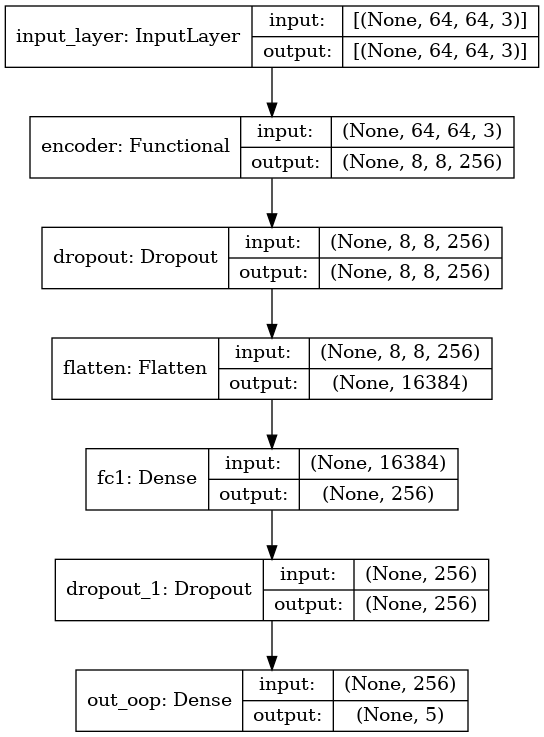

In [7]:
tf.keras.utils.plot_model(fin, show_shapes=True)

## 1. OOP train using encoder

In [3]:
## 1. Load & Prepare Data
openloader = load_opendata()
X_open, Y_open = openloader.load_data(classifier_label="OOP", dsize=(64,64), comp_ratio=4)

myloader = load_mydata()
X_my, Y_my = myloader.load_data(classifier_label="OOP", dsize=(64,64), comp_ratio=10, verbose=0)
X_my_test, Y_my_test = myloader.load_test_data(classifier_label="OOP", dsize=(64,64), comp_ratio=4, verbose=0)

print("Open data is ", len(X_open),", My Train set is ", len(Y_my),  ",  My Test set is ", len(Y_my_test))

Train opendata with Label(OOP): 100%|██████████| 22424/22424 [00:16<00:00, 1372.80it/s]
Train data Loading with OOP: 24821it [00:05, 4514.58it/s]
Test data Loading with OOP: 2000it [00:01, 1067.90it/s]

Open data is  1701 , My Train set is  1021 ,  My Test set is  341


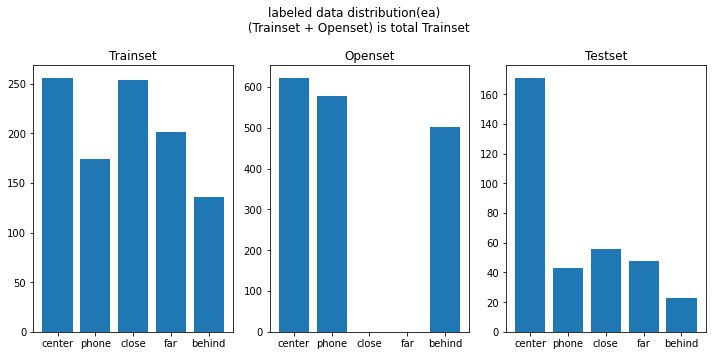

In [4]:
## 2. Data Class Distribution
count_center =0
count_phone =0
count_close =0
count_far =0
count_behind =0

for idx, i in enumerate(Y_my):
    if ( i == 'c0'):
        count_center +=1
    elif ( i == 'c1'):
        count_phone+=1
    elif ( i == 'c5'):
        count_close+=1
    elif ( i == 'c6'):
        count_far+=1    
    elif ( i == 'c7'):
        count_behind+=1

count_test_center =0
count_test_phone =0
count_test_close =0
count_test_far =0
count_test_behind =0

for idx, i in enumerate(Y_my_test):
    if ( i == 'c0'):
        count_test_center +=1
    elif ( i == 'c1'):
        count_test_phone+=1
    elif ( i == 'c5'):
        count_test_close+=1
    elif ( i == 'c6'):
        count_test_far+=1    
    elif ( i == 'c7'):
        count_test_behind+=1

count_open_center =0
count_open_phone =0
count_open_close =0
count_open_far =0
count_open_behind =0

for idx, i in enumerate(Y_open):
    if ( i == 'c0'):
        count_open_center +=1
    elif ( i == 'c1'):
        count_open_phone+=1
    elif ( i == 'c5'):
        count_open_close+=1
    elif ( i == 'c6'):
        count_open_far+=1    
    elif ( i == 'c7'):
        count_open_behind+=1

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(10,5))
plt.suptitle('labeled data distribution(ea) \n (Trainset + Openset) is total Trainset')
ax1.set_title('Trainset')
ax1.bar(['center','phone', 'close', 'far', 'behind'],[count_center, count_phone, count_close, count_far, count_behind])
ax2.set_title('Openset')
ax2.bar(['center','phone', 'close', 'far', 'behind'],[count_open_center, count_open_phone, count_open_close, count_open_far, count_open_behind])
ax3.set_title('Testset')
ax3.bar(['center','phone', 'close', 'far', 'behind'],[count_test_center, count_test_phone, count_test_close, count_test_far, count_test_behind])

plt.tight_layout()

In [5]:
## 3. Data preprocessing

# Normalized Image
X1 = preprocess(X_my, shape = (64,64,3))
X2 = preprocess(X_open, shape=(64,64,3))
X = np.concatenate((X1, X2), axis=0)
Y = np.concatenate((Y_my, Y_open), axis=0)

X_test_oop = preprocess(X_my_test, shape=(64,64,3))

# Data Augmentation (5%*3=15%)
X, Y = augment(X, labels=Y, ratio=0.05)

# Shuffled Image
X, Y = shuffler(X, Y)

# One-hot encoding
label_map, label_str = label_dict_static(classifier="OOP")
Y = np.array(list(map(lambda x: label_map[x], Y)))
Y = to_categorical(Y)

y_test = np.array(list(map(lambda x: label_map[x], Y_my_test)))
y_test_oop = to_categorical(y_test)

Augmentation samples are 408


In [6]:
## 4. Split Data in train mode
# Train, Val, Test Split
from sklearn.model_selection import train_test_split
X_train_oop, X_val_oop, y_train_oop, y_val_oop = train_test_split(X, Y, test_size=0.2, stratify=Y) 
print("X_train: {}\ny_train: {}\nX_val: {}\ny_val: {}\nX_test: {}\ny_test: {}".format(X_train_oop.shape, y_train_oop.shape, X_val_oop.shape, y_val_oop.shape, X_test_oop.shape, y_test_oop.shape))

X_train: (2504, 64, 64, 3)
y_train: (2504, 5)
X_val: (626, 64, 64, 3)
y_val: (626, 5)
X_test: (341, 64, 64, 3)
y_test: (341, 5)


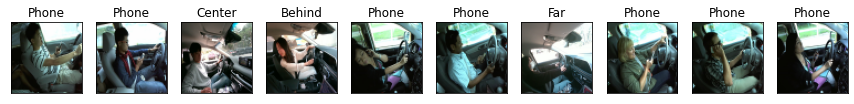

(2504, 64, 64, 3)


In [7]:
display_row(X_train_oop, y_train_oop, label_map, label_str)

In [ ]:
# # # # ## 5. Prepare Training Dummy label

# # # # #oop_dummy_label_train = np.zeros(shape=(len(y_train_oop),5))
# # # # weak_dummy_label_train = np.zeros(shape=(len(y_train_oop),2), dtype=float)
# # # # mask_dummy_label_train = np.zeros(shape=(len(y_train_oop),2), dtype=float)

# # # # #oop_dummy_label_val = np.zeros(shape=(len(y_val_oop),5))
# # # # weak_dummy_label_val = np.zeros(shape=(len(y_val_oop),2), dtype=float)
# # # # mask_dummy_label_val = np.zeros(shape=(len(y_val_oop),2), dtype=float)

# # # # #oop_dummy_label_test = np.zeros(shape=(len(y_test_val),5))
# # # # weak_dummy_label_test = np.zeros(shape=(len(y_test_oop),2), dtype=float)
# # # # mask_dummy_label_test = np.zeros(shape=(len(y_test_oop),2), dtype=float)

In [13]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


adam = Adam(learning_rate=0.001)
rl_callback = ReduceLROnPlateau(monitor='val_acc', factor=0.1, patience=7, min_delta=0.001)
es_callback = EarlyStopping(monitor='val_acc', min_delta=0.0001, patience=9)
filepath = os.path.join(os.getcwd(), "ckpt/", "Encoder_OOP-{epoch:01d}-{val_acc:.2f}.h5")
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

fin.compile(optimizer = adam,
            loss='categorical_crossentropy',
            metrics=['acc', tf.keras.metrics.AUC(thresholds=[0.5,0.7,0.9,0.95])],
            )

In [14]:
history = fin.fit(x=X_train_oop, y=y_train_oop,
                 epochs=25, batch_size=32, shuffle=True,
                 validation_data=(X_val_oop, y_val_oop),
                 callbacks=[rl_callback, es_callback, checkpoint])

Epoch 1/25
78/78 [==============================] - 29s 368ms/step - loss: 1.3549 - acc: 0.4899 - auc: 0.6518 - val_loss: 0.6389 - val_acc: 0.7729 - val_auc: 0.7700

Epoch 00001: val_acc improved from -inf to 0.77295, saving model to /home/joker1251/Desktop/owen/DataAnalysis_Science/DS_Master_21/Project/ckpt/Encoder_OOP-1-0.77.h5
Epoch 2/25
78/78 [==============================] - 32s 406ms/step - loss: 0.7656 - acc: 0.6698 - auc: 0.7641 - val_loss: 0.5010 - val_acc: 0.8341 - val_auc: 0.8610

Epoch 00002: val_acc improved from 0.77295 to 0.83414, saving model to /home/joker1251/Desktop/owen/DataAnalysis_Science/DS_Master_21/Project/ckpt/Encoder_OOP-2-0.83.h5
Epoch 3/25
78/78 [==============================] - 31s 400ms/step - loss: 0.6198 - acc: 0.7355 - auc: 0.8184 - val_loss: 0.4242 - val_acc: 0.8341 - val_auc: 0.8893

Epoch 00003: val_acc did not improve from 0.83414
Epoch 4/25
78/78 [==============================] - 30s 384ms/step - loss: 0.5389 - acc: 0.7806 - auc: 0.8517 - val_l

In [16]:
# Test using X_test data
X_pred=fin.predict(X_test_oop)
score(X_pred, y_test_oop)

Test Predict is: 98.23529411764706%


0.9823529411764705

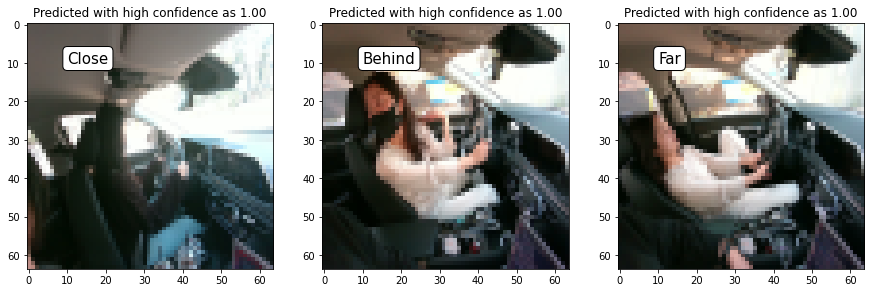

In [29]:
fig, ax = plt.subplots(1, 3, figsize = (15,5))
for i in range(3):
    matching_plot(X_test_oop, X_pred, y_test_oop, ax[i], label_map, label_str, thd=0.8)
plt.show()

In [75]:
import utils.xai_viz
from utils.xai_viz import explainable_model
importlib.reload(utils.xai_viz)

xai = explainable_model(fin)

Text(0.5, 1.0, 'Predicted: 2 as 1.000,    Label: 0')

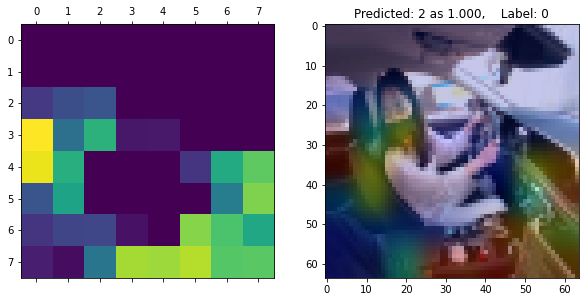

In [79]:
pick = random.randint(0, len(X_test_oop)-1)

heatmap = xai.explainable_model(X_test_oop[pick], "dropout", alpha=0.4)
fig_title = "Predicted: {} as {:.3f}".format(np.argmax(X_pred[pick]), X_pred[pick][np.argmax(X_pred[pick])])  +   ",    Label: {}".format(np.argmax(y_test[pick]))  
plt.title(fig_title)

In [33]:
# Save Model
fin.save('./ckpt/model_encoder_oop')

INFO:tensorflow:Assets written to: ./ckpt/model_encoder_oop/assets


## 2. Weak train using encoder

In [80]:
myloader = load_mydata()
X_my, Y_my = myloader.load_data(classifier_label="Weak", dsize=(64,64), comp_ratio=4, verbose=0)
X_my_test, Y_my_test = myloader.load_test_data(classifier_label="Weak", dsize=(64,64), comp_ratio=4, verbose=0)

print("My Train set is ", len(Y_my),  ",  My Test set is ", len(Y_my_test))

Train data Loading with Weak: 24821it [00:51, 478.19it/s]
Test data Loading with Weak: 2000it [00:04, 457.01it/s]

My Train set is  6227 ,  My Test set is  524


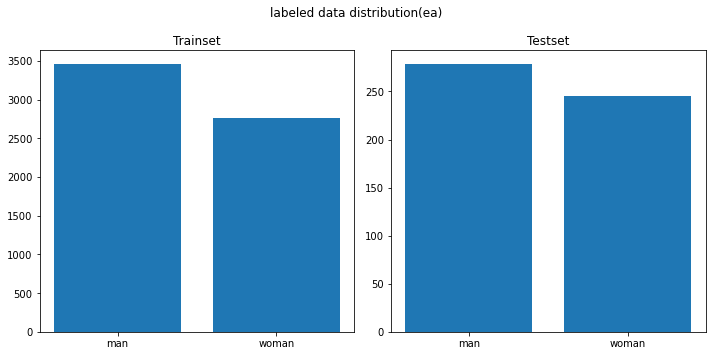

In [81]:
count_man =0
count_woman =0

for idx, i in enumerate(Y_my):
    if ( i == 's0'):
        count_man +=1
    elif ( i == 's1'):
        count_woman+=1

count_test_man =0
count_test_woman =0

for idx, i in enumerate(Y_my_test):
    if ( i == 's0'):
        count_test_man +=1
    elif ( i == 's1'):
        count_test_woman +=1

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
plt.suptitle('labeled data distribution(ea)')
ax1.set_title('Trainset')
ax1.bar(['man','woman'],[count_man, count_woman])

ax2.set_title('Testset')
ax2.bar(['man','woman'],[count_test_man, count_test_woman])

plt.tight_layout()

In [82]:
# Normalized Image
X = preprocess(X_my, shape = (64,64,3))
X_test_weak = preprocess(X_my_test, shape=(64,64,3))

# Data Augmentation (5%*3=15%)
X, Y = augment(X, labels=Y_my, ratio=0.05)

# Shuffled Image
X, Y = shuffler(X, Y)

# One-hot encoding
label_map, label_str = label_dict_static(classifier="Weak")
Y = np.array(list(map(lambda x: label_map[x], Y)))
Y = to_categorical(Y)

y_test = np.array(list(map(lambda x: label_map[x], Y_my_test)))
y_test_weak  = to_categorical(y_test)

Augmentation samples are 933


In [84]:
X_train_weak , X_val_weak , y_train_weak , y_val_weak  = train_test_split(X, Y, test_size=0.2, stratify=Y) 
print("X_train: {}\ny_train: {}\nX_val: {}\ny_val: {}\nX_test: {}\ny_test: {}".format(X_train_weak.shape, y_train_weak.shape, X_val_weak.shape, y_val_weak.shape, X_test_weak.shape, y_test_weak.shape))

X_train: (5728, 64, 64, 3)
y_train: (5728, 2)
X_val: (1432, 64, 64, 3)
y_val: (1432, 2)
X_test: (524, 64, 64, 3)
y_test: (524, 2)


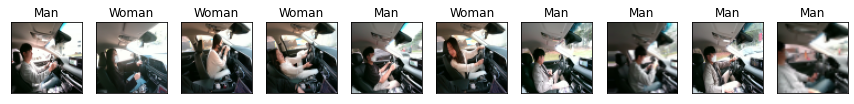

(5728, 64, 64, 3)


In [85]:
display_row(X_train_weak , y_train_weak , label_map, label_str)

In [86]:
fin_weak = model_classifier_with_encoder(encoder, train_classifier="Weak")
fin_weak.summary()

Model: "enc_weak"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 64, 64, 3)]       0         
_________________________________________________________________
encoder (Functional)         (None, 8, 8, 256)         1029248   
_________________________________________________________________
dropout_2 (Dropout)          (None, 8, 8, 256)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
fc2 (Dense)                  (None, 128)               2097280   
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
out_weak (Dense)             (None, 2)                 258

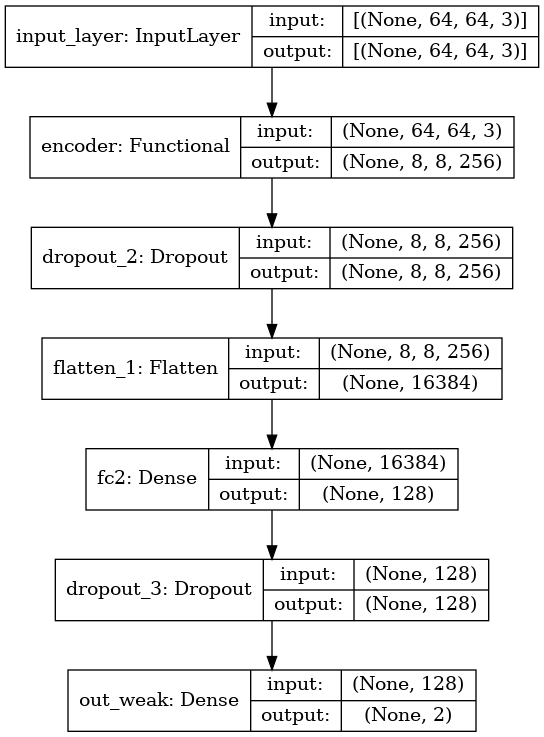

In [87]:
tf.keras.utils.plot_model(fin_weak, show_shapes=True)

In [90]:
adam = Adam(learning_rate=0.001)
rl_callback = ReduceLROnPlateau(monitor='val_acc', factor=0.1, patience=2, min_delta=0.001)
es_callback = EarlyStopping(monitor='val_acc', min_delta=0.0001, patience=3)
filepath = os.path.join(os.getcwd(), "ckpt/", "Encoder_Weak-{epoch:01d}-{val_acc:.2f}.h5")
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

fin_weak.compile(optimizer = adam,
            loss='categorical_crossentropy',
            metrics=['acc', tf.keras.metrics.AUC(thresholds=[0.5,0.7,0.9,0.95])],
            )

In [91]:
history = fin_weak.fit(x=X_train_weak, y=y_train_weak,
                 epochs=7, batch_size=32, shuffle=True,
                 validation_data=(X_val_weak, y_val_weak),
                 callbacks=[rl_callback, es_callback, checkpoint])

Epoch 1/7
179/179 [==============================] - 104s 574ms/step - loss: 0.1006 - acc: 0.9747 - auc_2: 0.9815 - val_loss: 0.0556 - val_acc: 0.9797 - val_auc_2: 0.9868

Epoch 00001: val_acc improved from -inf to 0.97975, saving model to /home/joker1251/Desktop/owen/DataAnalysis_Science/DS_Master_21/Project/ckpt/Encoder_Weak-1-0.98.h5
Epoch 2/7
179/179 [==============================] - 94s 528ms/step - loss: 0.0237 - acc: 0.9918 - auc_2: 0.9950 - val_loss: 0.0247 - val_acc: 0.9895 - val_auc_2: 0.9939

Epoch 00002: val_acc improved from 0.97975 to 0.98953, saving model to /home/joker1251/Desktop/owen/DataAnalysis_Science/DS_Master_21/Project/ckpt/Encoder_Weak-2-0.99.h5
Epoch 3/7
179/179 [==============================] - 94s 525ms/step - loss: 0.0248 - acc: 0.9907 - auc_2: 0.9943 - val_loss: 0.0196 - val_acc: 0.9923 - val_auc_2: 0.9950

Epoch 00003: val_acc improved from 0.98953 to 0.99232, saving model to /home/joker1251/Desktop/owen/DataAnalysis_Science/DS_Master_21/Project/ckpt/En

In [92]:
# Test using X_test data
X_pred=fin_weak.predict(X_test_weak)
score(X_pred, y_test_weak)

Test Predict is: 100.0%


1.0

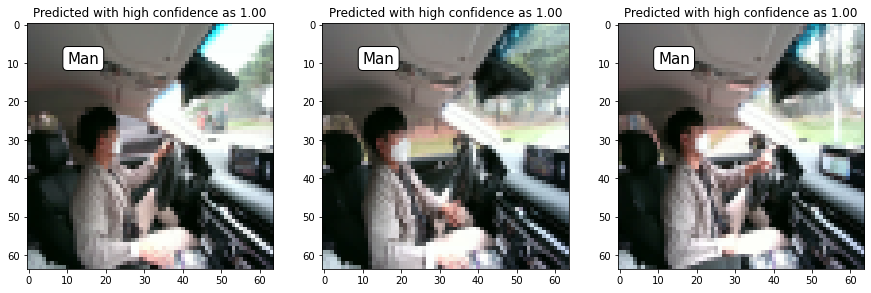

In [96]:
fig, ax = plt.subplots(1, 3, figsize = (15,5))
for i in range(3):
    matching_plot(X_test_weak, X_pred, y_test_weak, ax[i], label_map, label_str, thd=0.8)
plt.show()

In [ ]:
import utils.xai_viz
from utils.xai_viz import explainable_model
importlib.reload(utils.xai_viz)

xai = explainable_model(fin_weak)

Text(0.5, 1.0, 'Predicted: 1 as 1.000,    Label: 1')

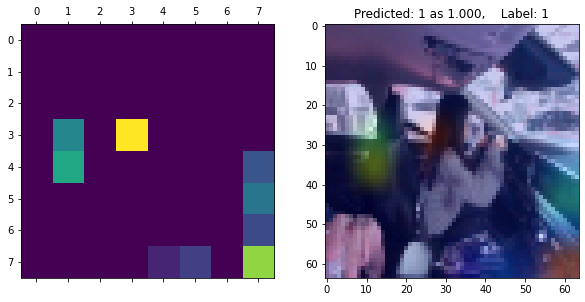

In [116]:
pick = random.randint(0, len(X_test_weak)-1)

heatmap = xai.explainable_model(X_test_weak[pick], "dropout", alpha=0.4)
fig_title = "Predicted: {} as {:.3f}".format(np.argmax(X_pred[pick]), X_pred[pick][np.argmax(X_pred[pick])])  +   ",    Label: {}".format(np.argmax(y_test_weak[pick]))  
plt.title(fig_title)

In [117]:
fin_weak.save("./ckpt/model_encoder_weak")

INFO:tensorflow:Assets written to: ./ckpt/model_encoder_weak/assets


## 3. Mask train using encoder

In [118]:
myloader = load_mydata()
X_my, Y_my = myloader.load_data(classifier_label="Mask", dsize=(64,64), comp_ratio=4, verbose=0)
X_my_test, Y_my_test = myloader.load_test_data(classifier_label="Mask", dsize=(64,64), comp_ratio=4, verbose=0)

print("My Train set is ", len(Y_my),  ",  My Test set is ", len(Y_my_test))

Train data Loading with Mask: 24821it [01:04, 383.08it/s]
Test data Loading with Mask: 2000it [00:05, 376.66it/s]

My Train set is  6227 ,  My Test set is  524


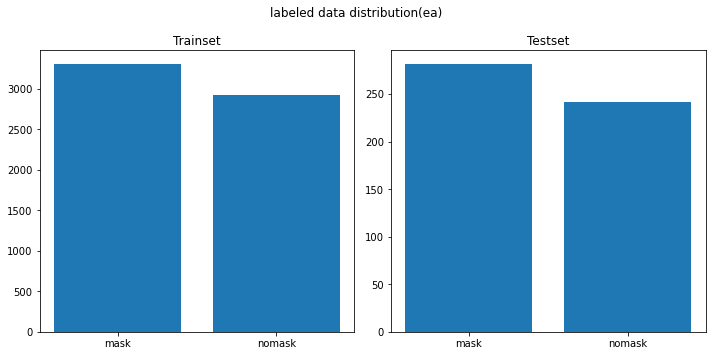

In [119]:
count_mask =0
count_nomask =0

for idx, i in enumerate(Y_my):
    if ( i == 'm0'):
        count_mask +=1
    elif ( i == 'm1'):
        count_nomask+=1


#마스크(m0: 0), 노마스크(m1: 1)

count_test_mask =0
count_test_nomask =0

for idx, i in enumerate(Y_my_test):
    if ( i == 'm0'):
        count_test_mask +=1
    elif ( i == 'm1'):
        count_test_nomask +=1

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
plt.suptitle('labeled data distribution(ea)')
ax1.set_title('Trainset')
ax1.bar(['mask','nomask'],[count_mask, count_nomask])

ax2.set_title('Testset')
ax2.bar(['mask','nomask'],[count_test_mask, count_test_nomask])

plt.tight_layout()

In [120]:
# Normalized Image
X = preprocess(X_my, shape = (64,64,3))
X_test_mask = preprocess(X_my_test, shape=(64,64,3))

# Data Augmentation (5%*3=15%)
X, Y = augment(X, labels=Y_my, ratio=0.05)

# Shuffled Image
X, Y = shuffler(X, Y)

# One-hot encoding
label_map, label_str = label_dict_static(classifier="Mask")
Y = np.array(list(map(lambda x: label_map[x], Y)))
Y = to_categorical(Y)

y_test = np.array(list(map(lambda x: label_map[x], Y_my_test)))
y_test_mask  = to_categorical(y_test)

Augmentation samples are 933


In [121]:
X_train_mask , X_val_mask , y_train_mask , y_val_mask  = train_test_split(X, Y, test_size=0.2, stratify=Y) 
print("X_train: {}\ny_train: {}\nX_val: {}\ny_val: {}\nX_test: {}\ny_test: {}".format(X_train_mask.shape, y_train_mask.shape, X_val_mask.shape, y_val_mask.shape, X_test_mask.shape, y_test_mask.shape))

X_train: (5728, 64, 64, 3)
y_train: (5728, 2)
X_val: (1432, 64, 64, 3)
y_val: (1432, 2)
X_test: (524, 64, 64, 3)
y_test: (524, 2)


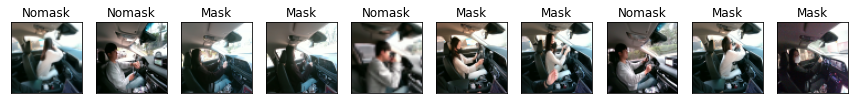

(5728, 64, 64, 3)


In [129]:
display_row(X_train_mask , y_train_mask , label_map, label_str)

In [130]:
fin_mask = model_classifier_with_encoder(encoder, train_classifier="Mask")
fin_mask.summary()

Model: "enc_mask"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 64, 64, 3)]       0         
_________________________________________________________________
encoder (Functional)         (None, 8, 8, 256)         1029248   
_________________________________________________________________
dropout_4 (Dropout)          (None, 8, 8, 256)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 16384)             0         
_________________________________________________________________
fc3 (Dense)                  (None, 128)               2097280   
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
out_mask (Dense)             (None, 2)                 258

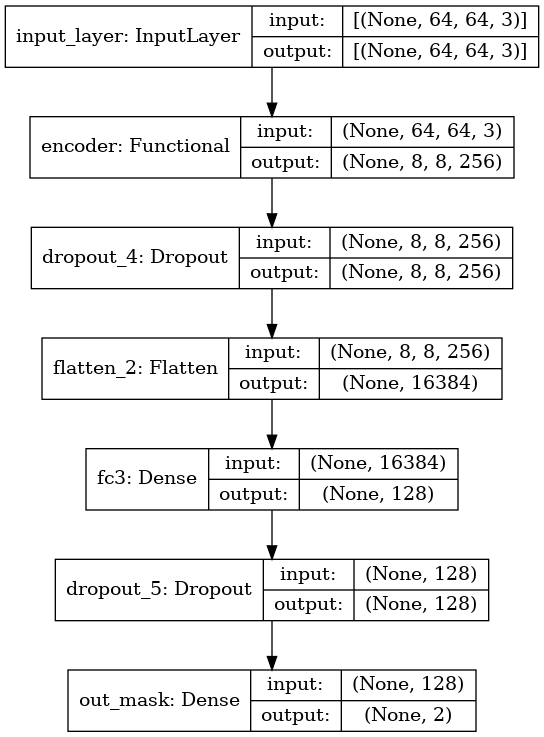

In [131]:
tf.keras.utils.plot_model(fin_mask, show_shapes=True)

In [140]:
adam = Adam(learning_rate=0.001)
rl_callback = ReduceLROnPlateau(monitor='val_acc', factor=0.1, patience=2, min_delta=0.001)
es_callback = EarlyStopping(monitor='val_acc', min_delta=0.0001, patience=3)
filepath = os.path.join(os.getcwd(), "ckpt/", "Encoder_Mask-{epoch:01d}-{val_acc:.2f}.h5")
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

fin_mask.compile(optimizer = adam,
            loss='categorical_crossentropy',
            metrics=['acc', tf.keras.metrics.AUC(thresholds=[0.5,0.7,0.9,0.95])],
            )

In [141]:
history = fin_mask.fit(x=X_train_mask, y=y_train_mask,
                 epochs=5, batch_size=32, shuffle=True,
                 validation_data=(X_val_mask, y_val_mask),
                 callbacks=[rl_callback, es_callback, checkpoint])

Epoch 1/5
179/179 [==============================] - 63s 349ms/step - loss: 0.2553 - acc: 0.8760 - auc_4: 0.9153 - val_loss: 0.1751 - val_acc: 0.9232 - val_auc_4: 0.9521

Epoch 00001: val_acc improved from -inf to 0.92318, saving model to /home/joker1251/Desktop/owen/DataAnalysis_Science/DS_Master_21/Project/ckpt/Encoder_Mask-1-0.92.h5
Epoch 2/5
179/179 [==============================] - 65s 361ms/step - loss: 0.2420 - acc: 0.8773 - auc_4: 0.9177 - val_loss: 0.1611 - val_acc: 0.9239 - val_auc_4: 0.9525

Epoch 00002: val_acc improved from 0.92318 to 0.92388, saving model to /home/joker1251/Desktop/owen/DataAnalysis_Science/DS_Master_21/Project/ckpt/Encoder_Mask-2-0.92.h5
Epoch 3/5
179/179 [==============================] - 67s 373ms/step - loss: 0.2341 - acc: 0.8858 - auc_4: 0.9236 - val_loss: 0.1616 - val_acc: 0.9330 - val_auc_4: 0.9586

Epoch 00003: val_acc improved from 0.92388 to 0.93296, saving model to /home/joker1251/Desktop/owen/DataAnalysis_Science/DS_Master_21/Project/ckpt/Enc

In [142]:
# Test using X_test data
X_pred=fin_mask.predict(X_test_mask)
score(X_pred, y_test_mask)

Test Predict is: 97.32824427480917%


0.9732824427480916

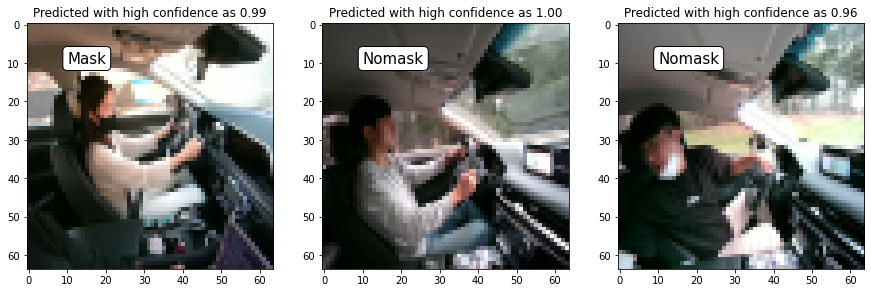

In [149]:
fig, ax = plt.subplots(1, 3, figsize = (15,5))
for i in range(3):
    matching_plot(X_test_mask, X_pred, y_test_mask, ax[i], label_map, label_str, thd=0.8)
plt.show()

In [150]:
import utils.xai_viz
from utils.xai_viz import explainable_model
importlib.reload(utils.xai_viz)

xai = explainable_model(fin_mask)

Text(0.5, 1.0, 'Predicted: 1 as 1.000,    Label: 1')

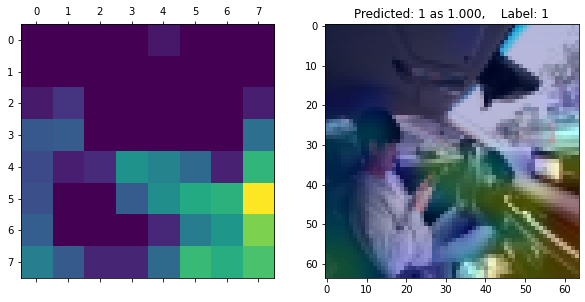

In [164]:
pick = random.randint(0, len(X_test_mask)-1)

heatmap = xai.explainable_model(X_test_mask[pick], "dropout_4", alpha=0.4)
fig_title = "Predicted: {} as {:.3f}".format(np.argmax(X_pred[pick]), X_pred[pick][np.argmax(X_pred[pick])])  +   ",    Label: {}".format(np.argmax(y_test_mask[pick]))  
plt.title(fig_title)

In [165]:
fin_mask.save("./ckpt/model_encoder_mask")

INFO:tensorflow:Assets written to: ./ckpt/model_encoder_mask/assets


In [166]:
fin.summary()

Model: "enc_oop"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 64, 64, 3)]       0         
_________________________________________________________________
encoder (Functional)         (None, 8, 8, 256)         1029248   
_________________________________________________________________
dropout (Dropout)            (None, 8, 8, 256)         0         
_________________________________________________________________
flatten (Flatten)            (None, 16384)             0         
_________________________________________________________________
fc1 (Dense)                  (None, 256)               4194560   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
out_oop (Dense)              (None, 5)                 1285

In [167]:
fin_weak.summary()

Model: "enc_weak"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 64, 64, 3)]       0         
_________________________________________________________________
encoder (Functional)         (None, 8, 8, 256)         1029248   
_________________________________________________________________
dropout_2 (Dropout)          (None, 8, 8, 256)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
fc2 (Dense)                  (None, 128)               2097280   
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
out_weak (Dense)             (None, 2)                 258

In [168]:
fin_mask.summary()

Model: "enc_mask"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 64, 64, 3)]       0         
_________________________________________________________________
encoder (Functional)         (None, 8, 8, 256)         1029248   
_________________________________________________________________
dropout_4 (Dropout)          (None, 8, 8, 256)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 16384)             0         
_________________________________________________________________
fc3 (Dense)                  (None, 128)               2097280   
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
out_mask (Dense)             (None, 2)                 258

# 멀티 헤드 모델로 조립하기

In [194]:
m_encoder = load_model("./ckpt/model_oop_autoencoder")

inputs = Input(shape=(64,64,3), name='encoder_input')
x1 = m_encoder.layers[1](inputs)
x3 = m_encoder.layers[3](x1)
x4 = m_encoder.layers[4](x3)
x5 = m_encoder.layers[5](x4)
x6 = m_encoder.layers[6](x5)
x7 = m_encoder.layers[7](x6)
x8 = m_encoder.layers[8](x7)
x9 = m_encoder.layers[9](x8)

encoder = Model(inputs = inputs, outputs = x9, name='encoder')

In [195]:
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 64, 64, 3)]       0         
_________________________________________________________________
enc_1st_conv (Conv2D)        (None, 64, 64, 64)        4864      
_________________________________________________________________
enc_1st_maxpool (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
enc_2nd_conv (Conv2D)        (None, 32, 32, 128)       204928    
_________________________________________________________________
enc_2nd_relu (ReLU)          (None, 32, 32, 128)       0         
_________________________________________________________________
enc_2nd_maxpool (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
enc_3rd_conv (Conv2D)        (None, 16, 16, 256)       8194

In [196]:
## oop
inputs = Input(shape=(16384), name='oop_input')
x1 = fin.layers[-3](inputs)
x2 = fin.layers[-2](x1)
x3 = fin.layers[-1](x2)

oop = Model(inputs = inputs, outputs = x3, name='oop_fc')


In [197]:
oop.summary()

Model: "oop_fc"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
oop_input (InputLayer)       [(None, 16384)]           0         
_________________________________________________________________
fc1 (Dense)                  (None, 256)               4194560   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
out_oop (Dense)              (None, 5)                 1285      
Total params: 4,195,845
Trainable params: 0
Non-trainable params: 4,195,845
_________________________________________________________________


In [198]:
## weak
inputs = Input(shape=(16384), name='weak_input')
x1 = fin_weak.layers[-3](inputs)
x2 = fin_weak.layers[-2](x1)
x3 = fin_weak.layers[-1](x2)

weak = Model(inputs = inputs, outputs = x3, name='weak_fc')

In [199]:
## mask
inputs = Input(shape=(16384), name='mask_input')
x1 = fin_mask.layers[-3](inputs)
x2 = fin_mask.layers[-2](x1)
x3 = fin_mask.layers[-1](x2)

mask = Model(inputs = inputs, outputs = x3, name='mask_fc')

In [200]:
importlib.reload(model.model_autoencoder)
from model.model_autoencoder import multihead_classifier_with_encoder

fin_multi=multihead_classifier_with_encoder(encoder, oop, weak, mask, input_shape=(64,64,3))

In [201]:
fin_multi.summary()

Model: "final_multi"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
encoder (Functional)            (None, 8, 8, 256)    1029248     input_layer[0][0]                
__________________________________________________________________________________________________
dropout_8 (Dropout)             (None, 8, 8, 256)    0           encoder[0][0]                    
__________________________________________________________________________________________________
flatten_5 (Flatten)             (None, 16384)        0           dropout_8[0][0]                  
________________________________________________________________________________________

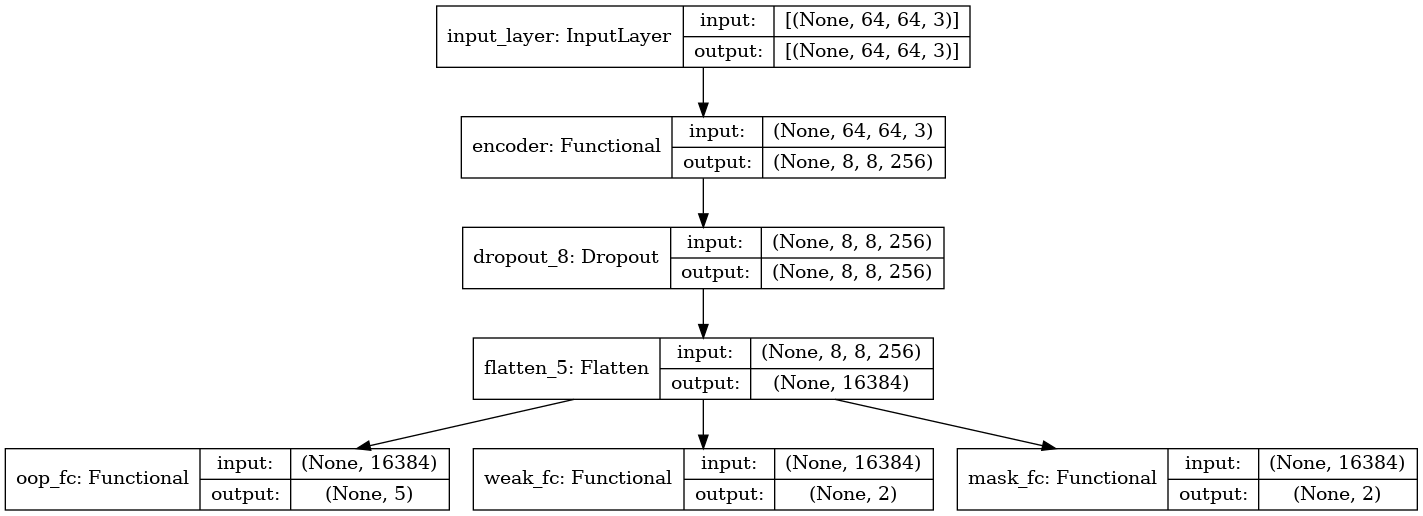

In [202]:
tf.keras.utils.plot_model(fin_multi, show_shapes=True)

In [203]:
fin_multi.save("./ckpt/model_encoder_multihead")

INFO:tensorflow:Assets written to: ./ckpt/model_encoder_multihead/assets


In [204]:
fin_multi.summary()

Model: "final_multi"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
encoder (Functional)            (None, 8, 8, 256)    1029248     input_layer[0][0]                
__________________________________________________________________________________________________
dropout_8 (Dropout)             (None, 8, 8, 256)    0           encoder[0][0]                    
__________________________________________________________________________________________________
flatten_5 (Flatten)             (None, 16384)        0           dropout_8[0][0]                  
________________________________________________________________________________________

## Final Multi Head model Assemble

In [36]:
m = load_model("./ckpt/model_encoder_multihead")

In [37]:
m.get_config()

{'name': 'final_multi',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 64, 64, 3),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'input_layer'},
   'name': 'input_layer',
   'inbound_nodes': []},
  {'class_name': 'Functional',
   'config': {'name': 'encoder',
    'layers': [{'class_name': 'InputLayer',
      'config': {'batch_input_shape': (None, 64, 64, 3),
       'dtype': 'float32',
       'sparse': False,
       'ragged': False,
       'name': 'encoder_input'},
      'name': 'encoder_input',
      'inbound_nodes': []},
     {'class_name': 'Conv2D',
      'config': {'name': 'enc_1st_conv',
       'trainable': False,
       'dtype': 'float32',
       'filters': 64,
       'kernel_size': (5, 5),
       'strides': (1, 1),
       'padding': 'same',
       'data_format': 'channels_last',
       'dilation_rate': (1, 1),
       'groups': 1,
       'activation': 'linear',
       'use_bias': True,
       'kernel_initializer':

In [18]:
m.summary()

Model: "final_multi"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
encoder (Functional)            (None, 8, 8, 256)    1029248     input_layer[0][0]                
__________________________________________________________________________________________________
dropout_8 (Dropout)             (None, 8, 8, 256)    0           encoder[0][0]                    
__________________________________________________________________________________________________
flatten_5 (Flatten)             (None, 16384)        0           dropout_8[0][0]                  
________________________________________________________________________________________

In [19]:
prediction = m.predict(X_test_oop)

In [20]:
prediction[2][10]

array([-1.251382 ,  2.9922419], dtype=float32)

### 이게 이상하긴 하다(211105, 모델을 조립해서 predict 하면 출력값의 합이 softmax activation이 있는데도 합이 1이 아닌게 이상해서, 직접 softmax 해보니까 합이 1이되는데,)
- 그말은, keras에서 Dense(5, activation='softmax') 한 것이 잘 작동하지 않았다는 것인데, 학습할 땐 잘되다가 여기선 왜 안되었지,, 사용상에 뭔가 오류가 잇는데

In [21]:
np.sum(np.exp(prediction[2][10][:])/np.sum(np.exp(prediction[2][10])))

0.99999994

In [14]:
score(prediction[0], y_test_oop)

Test Predict is: 98.61111111111111%


0.9861111111111112

In [209]:
prediction = m.predict(X_test_weak)
score(prediction[1], y_test_weak)

Test Predict is: 100.0%


1.0

In [210]:
prediction = m.predict(X_test_mask)
score(prediction[2], y_test_mask)

Test Predict is: 97.32824427480917%


0.9732824427480916